In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
#!pip install dask[dataframe]
#!pip install pandas --upgrade
# We have to do this as dask is bad at guessing the types of objects for some reason
# Also, if you are having trouble with running the dataframe and continuously get 
# Fatal Python error: GC object already tracked, try to update pandas
data_types = {
    'ID':  np.int64,
    'Case Number':  object,
    'Date': object,
    'Block': object,
    'IUCR': object,
    'Primary Type': object,
    'Description':  object,
    'Location Description': object,
    'Arrest':  bool,
    'Domestic': bool,
    'Beat': np.int64,
    'District': np.float64,
    'Ward': np.float64,
    'Community Area': np.float64,
    'FBI Code': object,
    'X Coordinate': np.float64,
    'Y Coordinate': np.float64,
    'Year': np.int64,
    'Updated On': object,
    'Latitude': np.float64,
    'Longitude': np.float64,
    'Location': object
}
df = pd.read_csv('crimes.csv')
data_subset = df.head(1000)


In [2]:
# Clean geolocation data if need be. Doesn't look like we have to, though
from geopy.geocoders import Nominatim
# Need to install geopy
#!pip install geopy
geolocator = Nominatim()
location = geolocator.geocode(data_subset['Block'][0])
# print location.latitude, location.longitude
# print data_subset['Latitude'][0], data_subset['Longitude'][0]


In [3]:
# Clean the data
# If we want to be able to count the number of arrests, then convert it to integers
# I suppose when the officer doesn't record the x coordinate, it becomes a zero for some reason.
# Remove those as well
df['int_Arrest'] = df['Arrest'].astype(int)
df['int_Domestic'] = df['Domestic'].astype(int)
df = df[df['X Coordinate'] != 0]

In [4]:
import numpy as np
from bokeh.plotting import figure, output_notebook, show
output_notebook()

def histogram(x,colors=None):
    hist,edges = np.histogram(x, bins=100)
    p = figure(y_axis_label="Pixels",
               tools='', height=130, outline_line_color=None,
               min_border=0, min_border_left=0, min_border_right=0,
               min_border_top=0, min_border_bottom=0)
    p.quad(top=hist[1:], bottom=0, left=edges[1:-1], right=edges[2:])
    print("min: {}, max: {}".format(np.min(x),np.max(x)))
    show(p)

Loading BokehJS ...

In [5]:
from bokeh.plotting import figure, output_notebook, show
# Unused for now.
def base_plot(tools='pan,wheel_zoom,reset',plot_width=900, plot_height=600, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

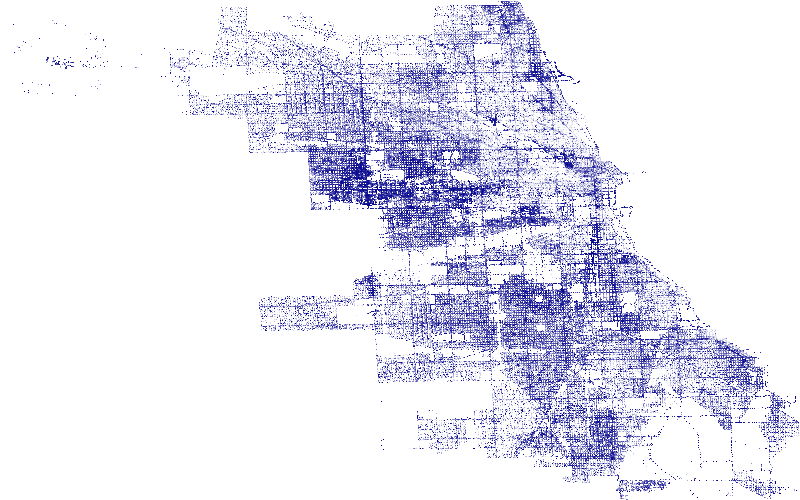

In [6]:
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import Greys9
Greys9_r = list(reversed(Greys9))[:-2]

x_range=(-91.686565684,-87.524529378)
y_range=(36.619446395,42.022910333)

cvs = ds.Canvas(plot_width=800, plot_height=500)
agg = cvs.points(df, 'X Coordinate', 'Y Coordinate',  ds.mean('int_Arrest'))
img = tf.interpolate(agg, cmap=["white", 'darkblue'], how='eq_hist')
img

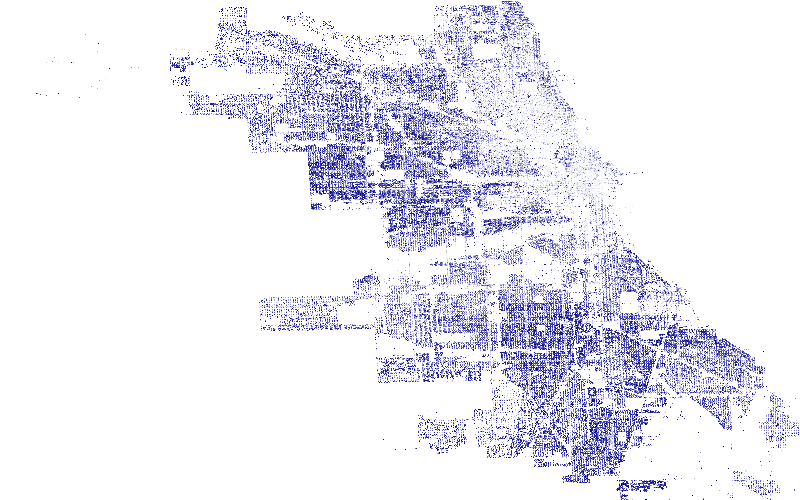

In [7]:
cvs = ds.Canvas(plot_width=800, plot_height=500)
agg = cvs.points(df, 'X Coordinate', 'Y Coordinate',  ds.mean('int_Domestic'))
img = tf.interpolate(agg, cmap=["white", 'darkblue'], how='eq_hist')
img

In [19]:
arrests = cvs.points(df, 'X Coordinate', 'Y Coordinate',  ds.mean('int_Arrest'))
crimes = cvs.points(df, 'X Coordinate', 'Y Coordinate',  ds.count('int_Arrest'))
# Remove nans to get mean arrests and crime
arr_mask = np.isnan(arrests.data)
crimes_mask = np.isnan(crimes.data)
mean_arrests = arrests.data[~arr_mask].mean()
mean_crimes = crimes.data[~crimes_mask].mean()
mean_ratio = mean_arrests/mean_crimes

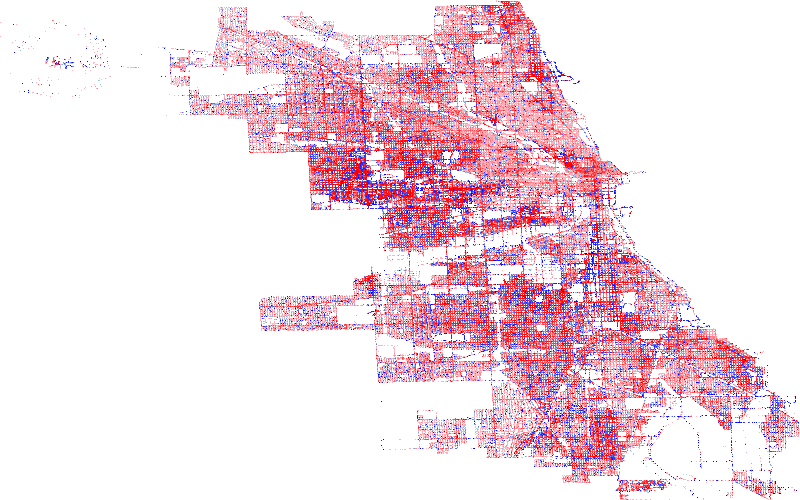

In [24]:
from datashader.callbacks import InteractiveImage
# Shows where there is more than an average amount of arrests to crimes
cvs = ds.Canvas(plot_width=800, plot_height=500)
more_arr = tf.interpolate(arrests.where(arrests/crimes > mean_ratio), cmap=["lightblue", 'blue'], how='eq_hist')
less_arr = tf.interpolate(arrests.where(arrests/crimes < mean_ratio), cmap=["lightpink", 'red'],  how='eq_hist')
img = tf.stack(more_arr,less_arr)
img